# Load libraries. Set precision and fonts

In [1]:
# reload
#%reset
%load_ext autoreload
%autoreload 2    
get_ipython().run_line_magic('precision', '3')
from helper_functions import *
plt.rcParams.update({'font.size': 22})
#from tabular_dae import DAE
from tabular_dae.model import DAE
from tabular_dae.model import load as dae_load

2024-02-01 13:47:34.535481: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-01 13:47:35.352759: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import torch

if torch.cuda.is_available():
    print("GPU is available.")
else:
    print("No GPU found.")
print(torch.cuda.device_count())
#print(torch.cuda.get_device_name(0))
#print(torch.cuda.current_device())

GPU is available.
1


# Set Parameters

In [5]:
model_save_path = 'models/'
train_slice = 'all' #['macro', 'micro', 'slow', 'fast', 'all', 'only_delay']
test_slice = 'all' #['macro', 'micro', 'slow', 'fast', 'all']

dae_pretrain = False
model_to_save_name = train_slice+'_dae_model_deepbottleneck40_numLayers5_hidSize150_noNA'

use_pretrained_model = True
model_to_load_name = train_slice+'_dae_model_deepbottleneck40_numLayers5_hidSize150_noNA'

hid_size = 150


dae_pretrain_runs = range(1, 12 + 1) # 1-12
train_runs = range(1, 12 + 1)
test_runs = range(13, 15 + 1)
#train_runs = range(1, 11 + 1)
#test_runs = range(12, 15 + 1)
#train_runs = range(16, 18 + 1)
#test_runs = range(19, 20 + 1)



time_step_size = '500ms'
#past_sample_step_size = '10ms'
past_samples = 1

fill_na_val = 0

# Column names in the dataset that contain the ground truth labels for our prediction tasks of interest
all_learning_tasks_in_data = ['dashClient_trace.txt_newBitRate_bps', # predictable with 0.3516 mape # most imp feature DlPdcpStats.txt_PduSize
                              'dashClient_trace.txt_oldBitRate_bps', 
                              'delay_trace.txt_ul_delay', # predictable with 0.06 mape # most imp feature UlPdcpStats.txt_delay
                              'delay_trace.txt_dl_delay', # predictable with 0.07 mape # most imp feature DlPdcpStats.txt_delay
                              'vrFragment_trace.txt_vr_frag_time', # predictable with 0.0394 mape # most imp feature DlPdcpStats.txt_delay
                              'vrFragment_trace.txt_vr_frag_thput_mbps', # predictable with 0.1150 mape # most imp feature DlPdcpStats.txt_delay
                              'vrFragment_trace.txt_vr_burst_time', # predictable with 0.0869 mape # most imp feature DlPdcpStats.txt_max
                              'vrFragment_trace.txt_vr_burst_thput_mbps']# predictable with 0.2122 mape # most imp feature DlPdcpStats.txt_delay 
learning_tasks = ['vrFragment_trace.txt_vr_frag_thput_mbps', 'vrFragment_trace.txt_vr_burst_thput_mbps',
                  'vrFragment_trace.txt_vr_frag_time', 'vrFragment_trace.txt_vr_burst_time']

classification = False 

# If True then we are predicting one window ahead if False then we are predicting on the same window 
shift_samp_for_predict = False

# If you want the test samples to be sorted by delay value to see the error differences for the low delay and high delay cases 
sort_test_samples = False

# CHECK
# Drop the other Y columns for other learning tasks
drop_cols = ['timestamp']

use_all_feats = True 
# take the top n features of each run and add it to the top_n_features list  
# If use_all_feats = True then thes will not be used 
feat_filter = 10 
top_n_features = []
# Only valid when use_all_feats = False 
selected_features = []

if classification:
    IN_PARAM = IN_PARAM_C
    OUT_PARAM = OUT_PARAM_C
else:
    IN_PARAM = IN_PARAM_R
    OUT_PARAM = OUT_PARAM_R
    IN_PARAM['loss'] = 'mse' # options are mse, mae and mape 
    IN_PARAM['eval_metric'] = 'mape' # options are mae, and mape
    
IN_PARAM['model_type'] = 'mlp'
IN_PARAM['time_wind_size'] = time_step_size

# All delay values above this will be removed from the train and test set
clip_outliers = True
delay_clip_th = 3000

# Read these from the ue_groups file later and also rename ue_groups to something else 
total_num_ues = 90
macro_cells = [1,2,3]
print('Macro CellIds: ', macro_cells)
micro_cells = [4,5,6]
print('Micro CellIds: ', micro_cells)
# I am copything this directly from the file 
macro_imsis = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
fast_imsis = [1,2,3,4,5,6]
only_delay_imsis = [3,5,7,9,13,15,17,19,23,25,27,29,33,35,37,39,43,45,47,49,53,55,57,59,63,65,67,69,73,75,77,79,83,85,87]
micro_imsis = list(set(range(1, total_num_ues+1)) - set(macro_imsis))
slow_imsis = list(set(range(1, total_num_ues+1)) - set(fast_imsis) - set(micro_imsis))

Macro CellIds:  [1, 2, 3]
Micro CellIds:  [4, 5, 6]


# Function definitions

In [6]:
# Takes a pandas df as input and selects samples that belong to a slice
def data_slice_filter_samples(slice, df):
    if slice == 'macro':
        # separate all the samples where cellId is in the macro_cells list
        filtered_df = df[df['cellId'].isin(macro_cells)]
    elif slice == 'micro':
        # separate all the samples where cellId is in the micro_cells list
        filtered_df = df[df['cellId'].isin(micro_cells)]
    elif slice == 'fast':
        # get all the fast IMSIs
        filtered_df = df[df['IMSI'].isin(fast_imsis)]
    elif slice == 'slow':
        filtered_df = df[df['IMSI'].isin(slow_imsis)]
    elif slice == 'all':
        # keep all return the whole slice
        filtered_df = df
    else:
        print('UNKNOWN SLICE NAME')
        filtered_df = df
    #print(filtered_df[['IMSI', 'cellId']].head(n=10) )
    return filtered_df

# Takes a pandas df as input and sets up dae pretraining. Returns the model  
def pretrain_with_dae(df):
    # initialize a dae model
    dae = DAE(
        body_network='deepbottleneck', # 'deepstack'
        body_network_cfg=dict(hidden_size=hid_size, num_layers=5, bottleneck_size=40), # batch_size=64
        swap_noise_probas=0.15,
        device='cuda')  
    # fit the model
    dae.fit(df, verbose=1, optimizer_params={'lr': 3e-4}, batch_size=64)
    return dae

# Process data frame before separating out learning task

In [7]:
# Set random seed
r = np.random.randint(0, 1000)
print('Run with random seed: ', r, '------------------------------------------------------------------------')    
IN_PARAM['rand_seed'] = r
np.random.seed(r)

# Read the dataset

if dae_pretrain:
    dae_pretrain_data = pd.DataFrame()
    print('DAE pretrain runs: ', dae_pretrain_runs)
    for run in dae_pretrain_runs:
        this_run_data = pd.read_csv('../../../dataset_ver1/parsed_data/run'+str(run)+'_dataslice_all_video_delay_vr_'+time_step_size+'.csv', delimiter=",")
        # separate the rows that belong to the desired data slice  
        this_run_data = data_slice_filter_samples(train_slice, this_run_data)
        dae_pretrain_data = pd.concat([dae_pretrain_data, this_run_data], axis=0)
        print('Loaded run', str(run))
        
    # Name the first column as timestamp
    dae_pretrain_data.rename(columns={dae_pretrain_data.columns[0]: 'timestamp'}, inplace=True)
    # Drop columns that we do not want to include in the dataset
    print('Drop unwanted columns')
    if use_all_feats:
        dae_pretrain_data = dae_pretrain_data.drop(expand_cols_to_step_size(drop_cols, past_samples), axis=1, errors='ignore')
    else:
        dae_pretrain_data = dae_pretrain_data[top_n_agg]
    print(dae_pretrain_data.shape)


print('Train runs: ', train_runs)
train_data = pd.DataFrame()
for run in train_runs:
    this_run_data = pd.read_csv('../../../dataset_ver1/parsed_data/run'+str(run)+'_dataslice_all_video_delay_vr_'+time_step_size+'.csv', delimiter=",")
    # separate the rows that belong to the desired data slice  
    this_run_data = data_slice_filter_samples(train_slice, this_run_data)
    train_data = pd.concat([train_data, this_run_data], axis=0)
    print('Loaded run', str(run))
# Name the first column as timestamp
train_data.rename(columns={train_data.columns[0]: 'timestamp'}, inplace=True)
# Drop columns that we do not want to include in the dataset
print('Drop unwanted columns')
if use_all_feats:
    train_data = train_data.drop(expand_cols_to_step_size(drop_cols, past_samples), axis=1, errors='ignore')
else:
    train_data = train_data[top_n_agg]
print(train_data.shape)


print('Test runs: ', test_runs)
test_data = pd.DataFrame()
for run in test_runs:
    this_run_data = pd.read_csv('../../../dataset_ver1/parsed_data/run'+str(run)+'_dataslice_all_video_delay_vr_'+time_step_size+'.csv', delimiter=",")
    # separate the rows that belong to the desired data slice  
    this_run_data = data_slice_filter_samples(test_slice, this_run_data)
    test_data = pd.concat([test_data, this_run_data], axis=0)
    print('Loaded run', str(run))
# Name the first column as timestamp
test_data.rename(columns={test_data.columns[0]: 'timestamp'}, inplace=True)
# Drop columns that we do not want to include in the dataset
print('Drop unwanted columns')
if use_all_feats:
    test_data = test_data.drop(expand_cols_to_step_size(drop_cols, past_samples), axis=1, errors='ignore')
else:
    test_data = test_data[top_n_agg]
print(test_data.shape)


# Save the column names
#np.savetxt('all_columns_list.csv', np.array(dae_pretrain_data.columns), delimiter=',', fmt="%s")

Run with random seed:  317 ------------------------------------------------------------------------
Train runs:  range(1, 13)
Loaded run 1
Loaded run 2
Loaded run 3
Loaded run 4
Loaded run 5
Loaded run 6
Loaded run 7
Loaded run 8
Loaded run 9
Loaded run 10
Loaded run 11
Loaded run 12
Drop unwanted columns
(2158920, 215)
Test runs:  range(13, 16)
Loaded run 13
Loaded run 14
Loaded run 15
Drop unwanted columns
(539730, 215)


# Pretrain using DAE 

In [8]:
if dae_pretrain:
    # Separate the X and the ys from the data
    # remove the labels of this and other prediction tasks which are also in the datset 
    X_pretrain = dae_pretrain_data.drop(all_learning_tasks_in_data, axis=1, errors='ignore')
    print(X_pretrain.shape)
    
    # Fill with 0 the values that are missing in the input features so that the sample can still be used
    print('Filling NA in samples with ', fill_na_val)
    print('Number of rows with NA values in the input features: ', len(X_pretrain[X_pretrain.isna().any(axis=1)]))
    print('Fraction of rows with NA values in the input features: ', len(X_pretrain[X_pretrain.isna().any(axis=1)])/X_pretrain.shape[0])
    X_pretrain = X_pretrain.fillna(fill_na_val)
    print('NOT imputing NA values and just keeing them as NAs instead')
    
    # Convert everything to numpy 
    #X_train = X_train.to_numpy() 
    
    val_scaler = create_normalizer(X_pretrain)
    dae_model = pretrain_with_dae(pd.DataFrame(val_scaler.transform(X_pretrain).copy()))
    # save this model for later use 
    dae_model.save(model_save_path+model_to_save_name)

# Train and test model 

Learning task:  vrFragment_trace.txt_vr_frag_thput_mbps
Dropping rows for which the label is NA, since there is no ground truth
(39613, 215)
(9904, 215)
(39613, 207)
(39613,)
(9904, 207)
(9904,)
Filling NA in samples with  0
train data shape (39613, 207)
test data shape (7428, 207)
val data shape (2476, 207)
Before DAE transform
(39613, 207)
Number of rows with NAs in the train set:  0
Number of rows with NAs in the val set:  0
   0    1         2         3    4         5    6         7    8         9    \
0  0.0  0.0  0.428571  0.000097  0.0  0.001427  0.0  0.000097  0.0  0.001427   
1  0.0  0.0  0.428571  0.000138  0.0  0.001100  0.0  0.000138  0.0  0.001100   
2  0.0  0.0  0.476190  0.000241  0.0  0.001668  0.0  0.000241  0.0  0.001668   
3  0.0  0.0  0.380952  0.000567  0.0  0.002118  0.0  0.000567  0.0  0.002118   
4  0.0  0.0  0.380952  0.001146  0.0  0.002091  0.0  0.001146  0.0  0.002091   

   ...       197       198       199  200       201       202       203  \
0  ...  0.00

/home/ubuntu/.local/lib/python3.8/site-packages/tabular_dae/data.py:19: RuntimeWarning: invalid value encountered in divide
  standardized = (np.array(x) - self.loc) / self.scale
/home/ubuntu/.local/lib/python3.8/site-packages/tabular_dae/data.py:19: RuntimeWarning: invalid value encountered in divide
  standardized = (np.array(x) - self.loc) / self.scale
/home/ubuntu/.local/lib/python3.8/site-packages/tabular_dae/data.py:19: RuntimeWarning: invalid value encountered in divide
  standardized = (np.array(x) - self.loc) / self.scale


After DAE transform
(39613, 40)
Number of rows with NAs in the train set:  0
Number of rows with NAs in the val set:  0
         0          1         2         3         4         5         6   \
0  4.482339 -10.105602 -7.617787  1.589668  3.440835 -1.088629 -7.474739   
1  4.276929  -9.959916 -7.507593  1.384173  3.170114 -1.065165 -7.627831   
2  3.478059 -10.679325 -6.713071  0.978890  4.044831 -1.402140 -6.920514   
3  2.624896 -10.519864 -6.443955  0.634225  3.998450 -1.669538 -7.116729   
4  2.899936 -10.395328 -7.101205  1.835927  3.221454 -1.958175 -7.690009   

         7         8         9   ...         30        31        32        33  \
0  0.319472  3.078481 -4.994536  ...  -9.762938 -0.461007 -3.176029  5.281168   
1  0.372727  2.921821 -5.125329  ...  -9.288439 -0.200026 -3.183672  5.078704   
2  1.467156  3.786694 -5.165744  ...  -9.808655 -0.606719 -2.521846  5.060244   
3  1.341749  3.687802 -6.087464  ... -10.405910 -0.286155 -2.299703  4.508469   
4  0.624543  3.628

2024-02-01 13:50:57.031862: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9949 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:82:00.0, compute capability: 6.1


Epoch 1/500


2024-02-01 13:50:58.679678: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f8870012f60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-01 13:50:58.679728: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2024-02-01 13:50:58.689738: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-01 13:50:59.223174: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902
2024-02-01 13:50:59.285513: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-01 13:50:59.359693: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


78/78 [==============================] - 3s 7ms/step - loss: 97.5405 - mean_absolute_percentage_error: 14783.0762 - val_loss: 31.9896 - val_mean_absolute_percentage_error: 9732.9219
Epoch 2/500
78/78 [==============================] - 0s 5ms/step - loss: 26.0403 - mean_absolute_percentage_error: 7945.2173 - val_loss: 13.3049 - val_mean_absolute_percentage_error: 6375.9912
Epoch 3/500
78/78 [==============================] - 0s 5ms/step - loss: 11.4596 - mean_absolute_percentage_error: 5292.4985 - val_loss: 5.6145 - val_mean_absolute_percentage_error: 4187.8613
Epoch 4/500
78/78 [==============================] - 0s 5ms/step - loss: 4.9650 - mean_absolute_percentage_error: 3495.3269 - val_loss: 2.3645 - val_mean_absolute_percentage_error: 2676.5618
Epoch 5/500
78/78 [==============================] - 0s 5ms/step - loss: 2.3929 - mean_absolute_percentage_error: 2264.1833 - val_loss: 1.1726 - val_mean_absolute_percentage_error: 1766.6315
Epoch 6/500
78/78 [==============================] 

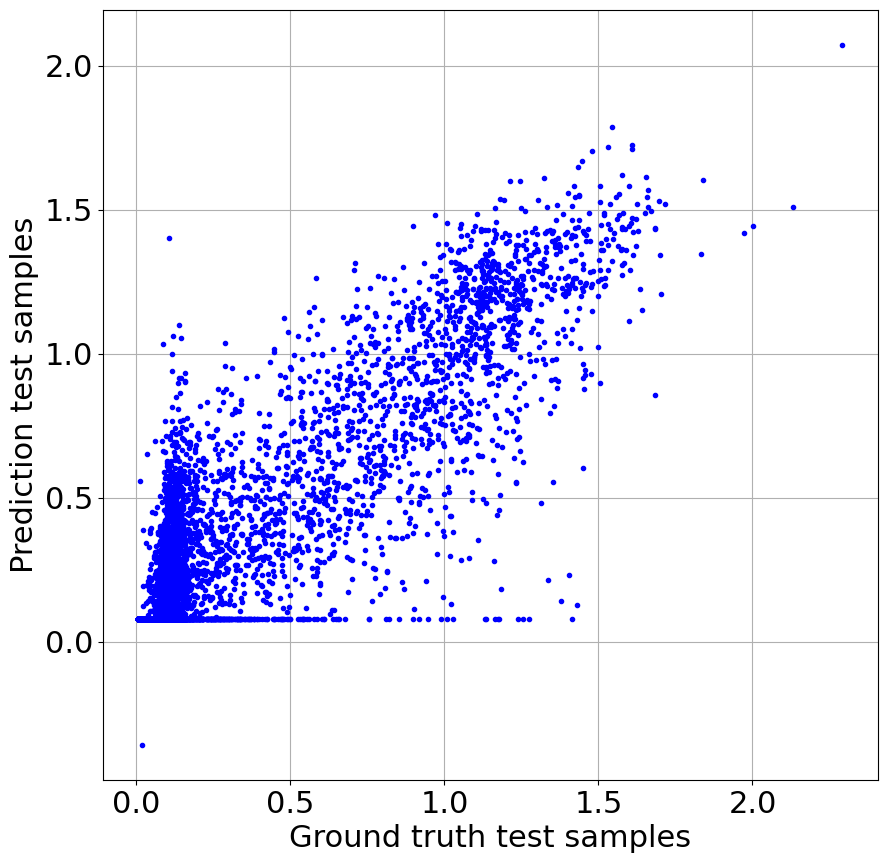



===============================  DONE  ===================================
Learning task:  vrFragment_trace.txt_vr_burst_thput_mbps
Dropping rows for which the label is NA, since there is no ground truth
(39593, 215)
(9897, 215)
(39593, 207)
(39593,)
(9897, 207)
(9897,)
Filling NA in samples with  0
train data shape (39593, 207)
test data shape (7422, 207)
val data shape (2475, 207)
Before DAE transform
(39593, 207)
Number of rows with NAs in the train set:  0
Number of rows with NAs in the val set:  0
   0    1         2         3    4         5    6         7    8         9    \
0  0.0  0.0  0.428571  0.000097  0.0  0.001427  0.0  0.000097  0.0  0.001427   
1  0.0  0.0  0.428571  0.000138  0.0  0.001100  0.0  0.000138  0.0  0.001100   
2  0.0  0.0  0.476190  0.000241  0.0  0.001668  0.0  0.000241  0.0  0.001668   
3  0.0  0.0  0.380952  0.000567  0.0  0.002118  0.0  0.000567  0.0  0.002118   
4  0.0  0.0  0.380952  0.001146  0.0  0.002091  0.0  0.001146  0.0  0.002091   

   ...   

/home/ubuntu/.local/lib/python3.8/site-packages/tabular_dae/data.py:19: RuntimeWarning: invalid value encountered in divide
  standardized = (np.array(x) - self.loc) / self.scale
/home/ubuntu/.local/lib/python3.8/site-packages/tabular_dae/data.py:19: RuntimeWarning: invalid value encountered in divide
  standardized = (np.array(x) - self.loc) / self.scale
/home/ubuntu/.local/lib/python3.8/site-packages/tabular_dae/data.py:19: RuntimeWarning: invalid value encountered in divide
  standardized = (np.array(x) - self.loc) / self.scale


After DAE transform
(39593, 40)
Number of rows with NAs in the train set:  0
Number of rows with NAs in the val set:  0
         0          1         2         3         4         5         6   \
0  4.473728 -10.085327 -7.590067  1.611858  3.417804 -1.068945 -7.493453   
1  4.268106  -9.949364 -7.488466  1.392281  3.162220 -1.050128 -7.623469   
2  3.474871 -10.664703 -6.696763  0.989211  4.031485 -1.389078 -6.945922   
3  2.627427 -10.503199 -6.430858  0.636400  3.995087 -1.651652 -7.116434   
4  2.901876 -10.383469 -7.084973  1.829977  3.223092 -1.942029 -7.676755   

         7         8         9   ...         30        31        32        33  \
0  0.324724  3.082466 -4.974311  ...  -9.735768 -0.455166 -3.172403  5.253111   
1  0.381555  2.937630 -5.107677  ...  -9.274921 -0.199435 -3.177688  5.060185   
2  1.468549  3.794877 -5.154799  ...  -9.785985 -0.582497 -2.524035  5.028747   
3  1.357030  3.695154 -6.074535  ... -10.388264 -0.275216 -2.298845  4.486920   
4  0.643177  3.639

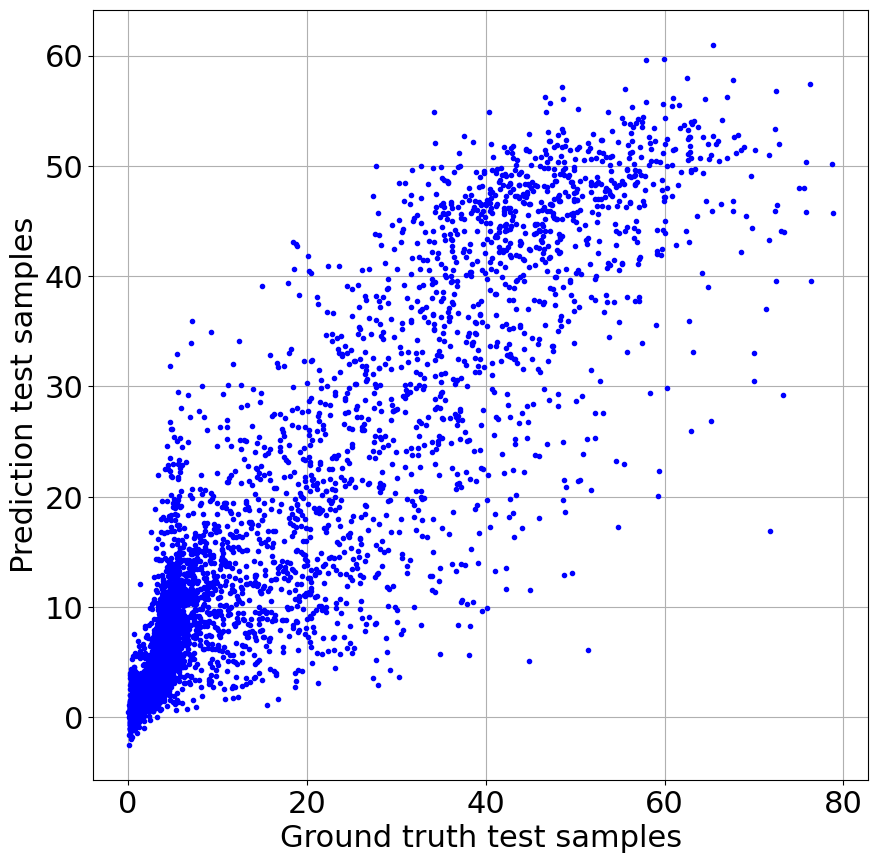



===============================  DONE  ===================================
Learning task:  vrFragment_trace.txt_vr_frag_time
Dropping rows for which the label is NA, since there is no ground truth
(39613, 215)
(9904, 215)
(39613, 207)
(39613,)
(9904, 207)
(9904,)
Filling NA in samples with  0
train data shape (39613, 207)
test data shape (7428, 207)
val data shape (2476, 207)
Before DAE transform
(39613, 207)
Number of rows with NAs in the train set:  0
Number of rows with NAs in the val set:  0
   0    1         2         3    4         5    6         7    8         9    \
0  0.0  0.0  0.428571  0.000097  0.0  0.001427  0.0  0.000097  0.0  0.001427   
1  0.0  0.0  0.428571  0.000138  0.0  0.001100  0.0  0.000138  0.0  0.001100   
2  0.0  0.0  0.476190  0.000241  0.0  0.001668  0.0  0.000241  0.0  0.001668   
3  0.0  0.0  0.380952  0.000567  0.0  0.002118  0.0  0.000567  0.0  0.002118   
4  0.0  0.0  0.380952  0.001146  0.0  0.002091  0.0  0.001146  0.0  0.002091   

   ...       197

/home/ubuntu/.local/lib/python3.8/site-packages/tabular_dae/data.py:19: RuntimeWarning: invalid value encountered in divide
  standardized = (np.array(x) - self.loc) / self.scale
/home/ubuntu/.local/lib/python3.8/site-packages/tabular_dae/data.py:19: RuntimeWarning: invalid value encountered in divide
  standardized = (np.array(x) - self.loc) / self.scale
/home/ubuntu/.local/lib/python3.8/site-packages/tabular_dae/data.py:19: RuntimeWarning: invalid value encountered in divide
  standardized = (np.array(x) - self.loc) / self.scale


After DAE transform
(39613, 40)
Number of rows with NAs in the train set:  0
Number of rows with NAs in the val set:  0
         0          1         2         3         4         5         6   \
0  4.482339 -10.105602 -7.617787  1.589668  3.440835 -1.088629 -7.474739   
1  4.276929  -9.959916 -7.507593  1.384173  3.170114 -1.065165 -7.627831   
2  3.478059 -10.679325 -6.713071  0.978890  4.044831 -1.402140 -6.920514   
3  2.624896 -10.519864 -6.443955  0.634225  3.998450 -1.669538 -7.116729   
4  2.899936 -10.395328 -7.101205  1.835927  3.221454 -1.958175 -7.690009   

         7         8         9   ...         30        31        32        33  \
0  0.319472  3.078481 -4.994536  ...  -9.762938 -0.461007 -3.176029  5.281168   
1  0.372727  2.921821 -5.125329  ...  -9.288439 -0.200026 -3.183672  5.078704   
2  1.467156  3.786694 -5.165744  ...  -9.808655 -0.606719 -2.521846  5.060244   
3  1.341749  3.687802 -6.087464  ... -10.405910 -0.286155 -2.299703  4.508469   
4  0.624543  3.628

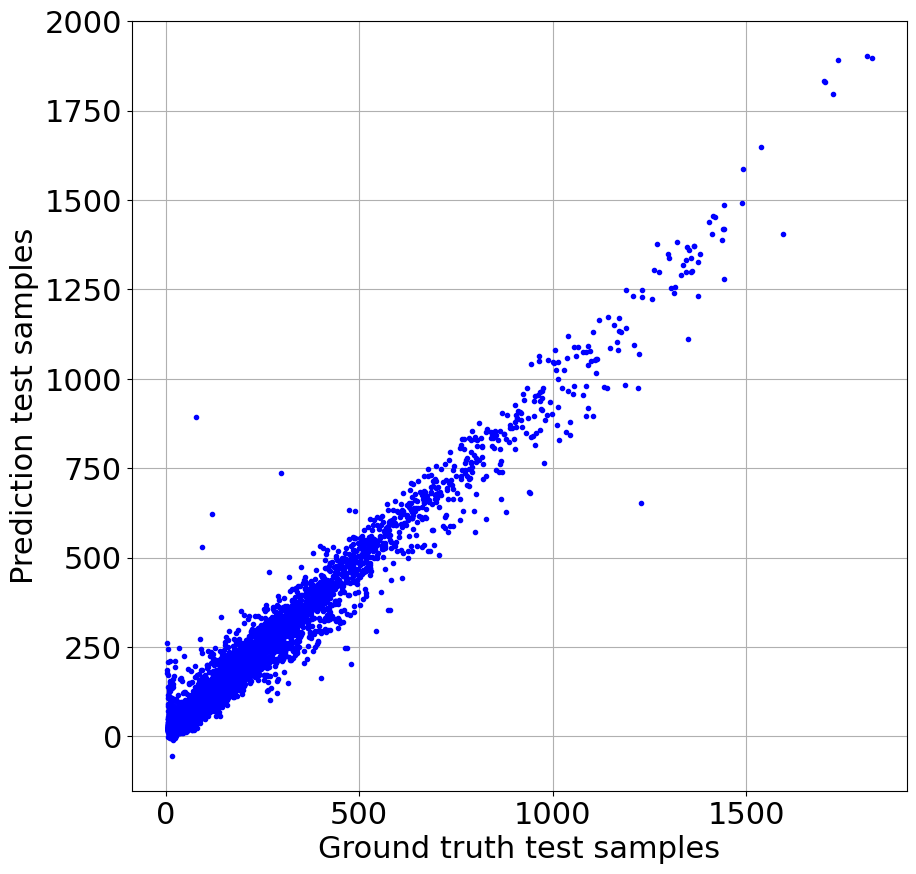



===============================  DONE  ===================================
Learning task:  vrFragment_trace.txt_vr_burst_time
Dropping rows for which the label is NA, since there is no ground truth
(39593, 215)
(9897, 215)
(39593, 207)
(39593,)
(9897, 207)
(9897,)
Filling NA in samples with  0
train data shape (39593, 207)
test data shape (7422, 207)
val data shape (2475, 207)
Before DAE transform
(39593, 207)
Number of rows with NAs in the train set:  0
Number of rows with NAs in the val set:  0
   0    1         2         3    4         5    6         7    8         9    \
0  0.0  0.0  0.428571  0.000097  0.0  0.001427  0.0  0.000097  0.0  0.001427   
1  0.0  0.0  0.428571  0.000138  0.0  0.001100  0.0  0.000138  0.0  0.001100   
2  0.0  0.0  0.476190  0.000241  0.0  0.001668  0.0  0.000241  0.0  0.001668   
3  0.0  0.0  0.380952  0.000567  0.0  0.002118  0.0  0.000567  0.0  0.002118   
4  0.0  0.0  0.380952  0.001146  0.0  0.002091  0.0  0.001146  0.0  0.002091   

   ...       19

/home/ubuntu/.local/lib/python3.8/site-packages/tabular_dae/data.py:19: RuntimeWarning: invalid value encountered in divide
  standardized = (np.array(x) - self.loc) / self.scale
/home/ubuntu/.local/lib/python3.8/site-packages/tabular_dae/data.py:19: RuntimeWarning: invalid value encountered in divide
  standardized = (np.array(x) - self.loc) / self.scale
/home/ubuntu/.local/lib/python3.8/site-packages/tabular_dae/data.py:19: RuntimeWarning: invalid value encountered in divide
  standardized = (np.array(x) - self.loc) / self.scale


After DAE transform
(39593, 40)
Number of rows with NAs in the train set:  0
Number of rows with NAs in the val set:  0
         0          1         2         3         4         5         6   \
0  4.473728 -10.085327 -7.590067  1.611858  3.417804 -1.068945 -7.493453   
1  4.268106  -9.949364 -7.488466  1.392281  3.162220 -1.050128 -7.623469   
2  3.474871 -10.664703 -6.696763  0.989211  4.031485 -1.389078 -6.945922   
3  2.627427 -10.503199 -6.430858  0.636400  3.995087 -1.651652 -7.116434   
4  2.901876 -10.383469 -7.084973  1.829977  3.223092 -1.942029 -7.676755   

         7         8         9   ...         30        31        32        33  \
0  0.324724  3.082466 -4.974311  ...  -9.735768 -0.455166 -3.172403  5.253111   
1  0.381555  2.937630 -5.107677  ...  -9.274921 -0.199435 -3.177688  5.060185   
2  1.468549  3.794877 -5.154799  ...  -9.785985 -0.582497 -2.524035  5.028747   
3  1.357030  3.695154 -6.074535  ... -10.388264 -0.275216 -2.298845  4.486920   
4  0.643177  3.639

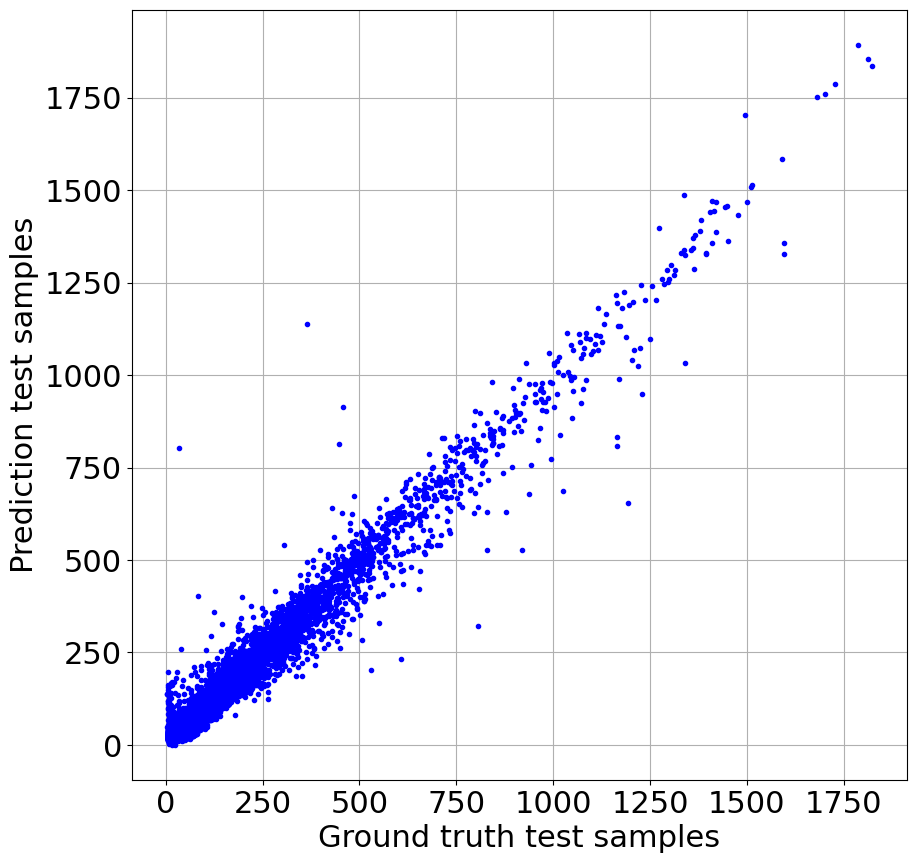



===============================  DONE  ===================================


In [9]:
for learning_task in learning_tasks:
    
    print('Learning task: ', learning_task)

    # Prepare the train and test sets
    
    # Drop rows when the label or ground truth is NA 
    print('Dropping rows for which the label is NA, since there is no ground truth')
    train_data_na_dropped = train_data.dropna(subset=[learning_task])
    test_data_na_dropped = test_data.dropna(subset=[learning_task])
    print(train_data_na_dropped.shape)
    print(test_data_na_dropped.shape)
    
    # Separate the X and the y from the data
    # separate out the prediction task label column 
    y_train = train_data_na_dropped[learning_task]
    y_test = test_data_na_dropped[learning_task]
    # remove the labels of this and other prediction tasks which are also in the datset 
    X_train = train_data_na_dropped.drop(all_learning_tasks_in_data, axis=1, errors='ignore')
    X_test = test_data_na_dropped.drop(all_learning_tasks_in_data, axis=1, errors='ignore')
    print(X_train.shape)
    print(y_train.shape)
    print(X_test.shape)
    print(y_test.shape)
    
    # Fill with 0 the values that are missing in the input features so that the sample can still be used
    print('Filling NA in samples with ', fill_na_val)
    X_train = X_train.fillna(fill_na_val)
    X_test = X_test.fillna(fill_na_val)

    if (learning_task in ['delay_trace.txt_ul_delay', 'delay_trace.txt_dl_delay']) and clip_outliers:
        print('NOTE: clipping all rows with delay values > ', delay_clip_th)
        y_train.loc[y_train > delay_clip_th] = delay_clip_th
        y_test.loc[y_test > delay_clip_th] = delay_clip_th
        #print('NOTE: dropping all rows with delay values > ', delay_drop_th)
        #data = data[data['owd_ul'] <= delay_drop_th]
    
    if classification:
        print('Class distribution')
        pd.set_option("display.max_rows", None)
        print(y_train.value_counts())
    
    # Save the columns to use for feature importance graphs
    X_feats = np.array(X_train.columns)
    np.savetxt('input_feature_list.csv', X_feats, delimiter=',', fmt="%s")

    # Convert everything to numpy 
    X_train = X_train.to_numpy()
    y_train = y_train.to_numpy()
    X_test = X_test.to_numpy()
    y_test = y_test.to_numpy()

    # If you want to shift the output feature window 
    # I am taking away this option since we are combining multiple runs and the values at the edge between 2 runs will be wrong
    # I need to shift before combining runs and drop the last sample if I want to do this here 
    #if shift_samp_for_predict: 
    #    y = np.roll(y,1)
    #    X = X[1:]
    #    y = y[1:]   

    if classification:
        strat = y_train
    else: 
        strat = None

    # Train test split
    # Random shift
    #sample_shift_count = np.random.randint(0, X.shape[0], size=1)
    #X = np.roll(X, sample_shift_count)
    #y = np.roll(y, sample_shift_count)
    
    # Randomly assign to train and test sets 
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, 
    #                                                    random_state=IN_PARAM['rand_seed'], stratify=strat) 
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, 
                                                  test_size=0.25, shuffle=True, 
                                                  random_state=IN_PARAM['rand_seed'],
                                                  stratify=strat)  
    
    print('train data shape ' + str(X_train.shape))
    print('test data shape ' + str(X_test.shape))
    print('val data shape ' + str(X_val.shape))

    # Plot hist of output
    # If classification it will just bin it
    #plt.figure(1)
    #plt.hist(y_train, bins=50, color='r', edgecolor='k', label='train samples')
    #plt.xlabel(learning_task)
    #plt.title('Histogram of train and test samples')
    #plt.legend()
    #plt.show()
    #plt.figure(2)
    #plt.hist(y_test, bins=50, color='b', edgecolor='k', label='test_samples')
    #plt.xlabel(learning_task)
    #plt.title('Histogram of train and test samples')
    #plt.legend()
    #plt.show()


    # WARNING. I think I should be using the same normalizer as the one I used for pretraining when I am starting with a pretrained model.  
    val_scaler = create_normalizer(X_train)
    X_train = val_scaler.transform(X_train).copy()
    X_test = val_scaler.transform(X_test).copy()
    X_val = val_scaler.transform(X_val).copy()

    # save the MinMaxscaler model to a file
    with open(model_save_path + 'minMaxScaler_'+IN_PARAM['model_type'] + '.pkl', 'wb') as f:
        pickle.dump(val_scaler, f)
    
    #=============================================== Train and test the model ==================================

    OUT_PARAM = dict.fromkeys(OUT_PARAM, 0)
    start_time = time.time()


    if use_pretrained_model:
        # get the latent representations from pretrained model
        # Load the pretrained model 
        print('Before DAE transform')
        print(X_train.shape)
        print('Number of rows with NAs in the train set: ', np.sum(np.any(np.isnan(X_train), axis=1)))
        print('Number of rows with NAs in the val set: ', np.sum(np.any(np.isnan(X_val), axis=1)))
        print(pd.DataFrame(X_train).head())
        print(X_train)
        dae_model = dae_load(model_save_path+model_to_load_name)
        
        X_train = dae_model.transform(pd.DataFrame(X_train))#[:, -hid_size:]
        X_test = dae_model.transform(pd.DataFrame(X_test))#[:, -hid_size:]
        X_val = dae_model.transform(pd.DataFrame(X_val))#[:, -hid_size:]
        print('After DAE transform')
        print(X_train.shape)
        
        #print('Fraction of rows with NA values in the input features: ', len(X_pretrain[X_pretrain.isna().any(axis=1)])/X_pretrain.shape[0])

        print('Number of rows with NAs in the train set: ', np.sum(np.any(np.isnan(X_train), axis=1)))
        print('Number of rows with NAs in the val set: ', np.sum(np.any(np.isnan(X_val), axis=1)))
        print(pd.DataFrame(X_train).head())
        
    
    
    model, history = evaluate_model(X_train, X_val, 
                                    y_train, y_val, 
                                    model_save_path + '/', 
                                    IN_PARAM)
    end_time = time.time()
    OUT_PARAM['runtime'] = end_time - start_time
    print('Time to train model: ', end_time - start_time)

    yhat_test = model.predict(X_test)
    yhat_train = model.predict(X_train)
    
    if classification:
        # This actually does regression but with class labels, so it can be a bit confusing that I call this classification 
        if IN_PARAM['loss'] == 'class_mse':
            # convert the continuous regression outputs to class labels 
            yhat_train = np.round(yhat_train)
            yhat_train[yhat_train > (num_classes-1)] = num_classes-1
            yhat_train[yhat_train < 0] = 0
            yhat_test = np.round(yhat_test)
            yhat_test[yhat_test > (num_classes-1)] = num_classes-1
            yhat_test[yhat_test < 0] = 0
    
    
        # create a confusion matrix
        cf_matrix = confusion_matrix(y_test, yhat_test, normalize='true')
        sns.set(rc={'figure.figsize':(8,7)}, font_scale = 1.5)
        sns.heatmap(cf_matrix, annot=True, 
            fmt='.1%', cmap='Blues')
    
        # get accuracy, precision and recall
        OUT_PARAM['train_acc'] = accuracy_score(yhat_train, y_train)
        OUT_PARAM['train_prec'], OUT_PARAM['train_rec'], train_fscore, train_support = precision_recall_fscore_support(yhat_train, y_train, average='macro')
        OUT_PARAM['test_acc'] = accuracy_score(yhat_test, y_test)
        OUT_PARAM['test_prec'], OUT_PARAM['test_rec'], test_fscore, test_support = precision_recall_fscore_support(yhat_test, y_test, average='macro')
        avg_acc_over_runs = avg_acc_over_runs + OUT_PARAM['test_acc']
        avg_prec_over_runs = avg_prec_over_runs + OUT_PARAM['test_prec']
        avg_rec_over_runs = avg_rec_over_runs + OUT_PARAM['test_rec']
        #avg_baseline_err_over_runs = avg_baseline_err_over_runs + ???
        print(OUT_PARAM)
        print('ML model: ', IN_PARAM['eval_metric'],' (acc, prec, recall) for test set: ',  OUT_PARAM['test_acc'], OUT_PARAM['test_prec'], OUT_PARAM['test_rec'])
    
    else:
        print(IN_PARAM['eval_metric'])
        OUT_PARAM['train_err'] = compute_error(y_train, yhat_train, IN_PARAM['eval_metric'])
        OUT_PARAM['test_err'] = compute_error(y_test, yhat_test, IN_PARAM['eval_metric'])
        print(OUT_PARAM)
        print('ML model: ', IN_PARAM['eval_metric'],' err for test set: ', OUT_PARAM['test_err'])
        print('Mean of the train set is: ', np.mean(y_train))
        print('Median of the train set is: ', np.median(y_train))
    
    


    plt.figure(figsize=(10, 10))
    plt.plot(y_test, yhat_test, 'b.')
    #plt.plot([0,0], [delay_drop_th, delay_drop_th], 'k-')
    plt.xlabel('Ground truth test samples')
    plt.ylabel('Prediction test samples')
    #plt.xlim(0,delay_clip_th+500)
    #plt.ylim(0,delay_clip_th+500)
    plt.grid()
    plt.show()
    
    
    if not os.path.isdir(model_save_path):
        os.makedirs(model_save_path)
    
            
    print('')
    print('')
    print('===============================  DONE  ===================================')

# This stuff is extra if I want to repeat the test set inference but not the training 

mape
{'runtime': 3.46917986869812, 'train_err_mape': 0, 'test_err_mape': 0, 'train_err': 0.03383812901523452, 'test_err': 0.053258504267054606}
ML model:  mape  err for test set:  0.053258504267054606
Mean of the train set is:  71.6516232041391
Median of the train set is:  15.531
(133495,)
(133495,)


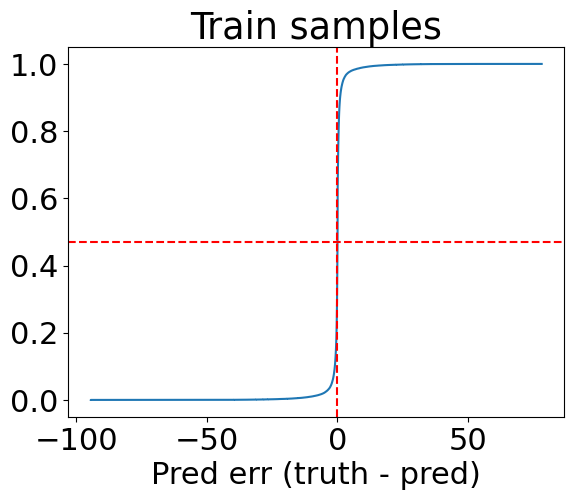

Train: Probability mass of pred err (truth-pred) below 0 is:  0.47030225851155477
Train: Probability mass of pred err (truth-pred) above 0 is:  0.5296977414884452


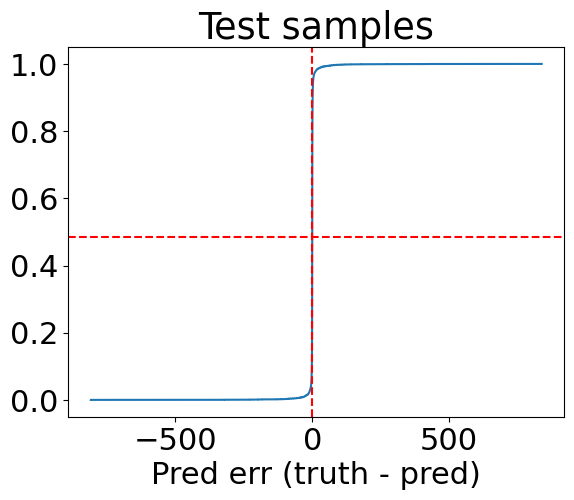

Test: Probability mass of pred err (truth-pred) below 0 is:  0.483629003452792
Test: Probability mass of pred err (truth-pred) above 0 is:  0.5163709965472081


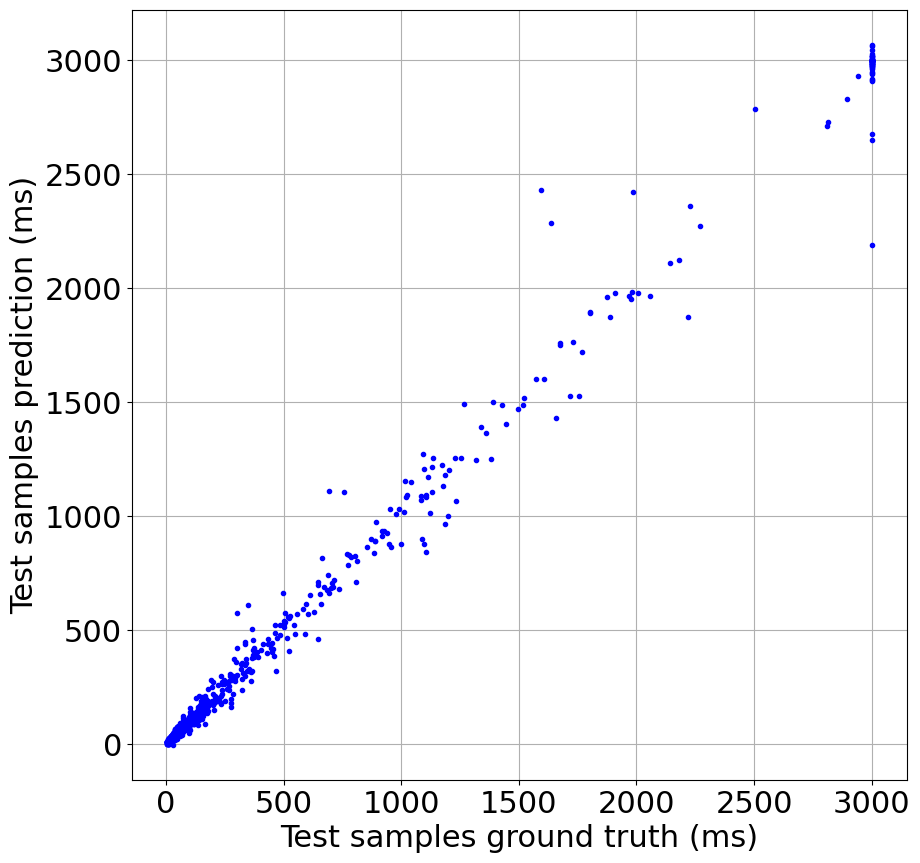



===============================  DONE  ===================================


In [59]:

yhat_test = model.predict(X_test)
yhat_train = model.predict(X_train)

if classification:
    # This actually does regression but with class labels, so it can be a bit confusing that I call this classification 
    if IN_PARAM['loss'] == 'class_mse':
        # convert the continuous regression outputs to class labels 
        yhat_train = np.round(yhat_train)
        yhat_train[yhat_train > (num_classes-1)] = num_classes-1
        yhat_train[yhat_train < 0] = 0
        yhat_test = np.round(yhat_test)
        yhat_test[yhat_test > (num_classes-1)] = num_classes-1
        yhat_test[yhat_test < 0] = 0


    # create a confusion matrix
    cf_matrix = confusion_matrix(y_test, yhat_test, normalize='true')
    sns.set(rc={'figure.figsize':(8,7)}, font_scale = 1.5)
    sns.heatmap(cf_matrix, annot=True, 
        fmt='.1%', cmap='Blues')

    # get accuracy, precision and recall
    OUT_PARAM['train_acc'] = accuracy_score(yhat_train, y_train)
    OUT_PARAM['train_prec'], OUT_PARAM['train_rec'], train_fscore, train_support = precision_recall_fscore_support(yhat_train, y_train, average='macro')
    OUT_PARAM['test_acc'] = accuracy_score(yhat_test, y_test)
    OUT_PARAM['test_prec'], OUT_PARAM['test_rec'], test_fscore, test_support = precision_recall_fscore_support(yhat_test, y_test, average='macro')
    avg_acc_over_runs = avg_acc_over_runs + OUT_PARAM['test_acc']
    avg_prec_over_runs = avg_prec_over_runs + OUT_PARAM['test_prec']
    avg_rec_over_runs = avg_rec_over_runs + OUT_PARAM['test_rec']
    #avg_baseline_err_over_runs = avg_baseline_err_over_runs + ???
    print(OUT_PARAM)
    print('ML model: ', IN_PARAM['eval_metric'],' (acc, prec, recall) for test set: ',  OUT_PARAM['test_acc'], OUT_PARAM['test_prec'], OUT_PARAM['test_rec'])

else: 
    print(IN_PARAM['eval_metric'])
    OUT_PARAM['train_err'] = compute_error(y_train, yhat_train, IN_PARAM['eval_metric'])
    OUT_PARAM['test_err'] = compute_error(y_test, yhat_test, IN_PARAM['eval_metric'])
    print(OUT_PARAM)
    print('ML model: ', IN_PARAM['eval_metric'],' err for test set: ', OUT_PARAM['test_err'])
    print('Mean of the train set is: ', np.mean(y_train))
    print('Median of the train set is: ', np.median(y_train))

    # plot the cdf of the train error 
    print(yhat_train.shape) # ,1
    print(y_train.shape) # ,
    yhat_train_a = np.squeeze(yhat_train)
    yhat_test_a = np.squeeze(yhat_test)
    ecdf_train = ECDF(yhat_train_a - y_train)
    plt.step(ecdf_train.x, ecdf_train.y)
    plt.axvline(x=0, color='red', linestyle='--')
    plt.axhline(y=ecdf_train(0), color='red', linestyle='--')
    plt.xlabel('Pred err (truth - pred)')
    plt.title('Train samples')
    #plt.hist((yhat_train - y_train), bins=200, edgecolor='k')
    #plt.xlim(-20, 50)
    plt.show()
    print('Train: Probability mass of pred err (truth-pred) below 0 is: ',  ecdf_train(0))
    print('Train: Probability mass of pred err (truth-pred) above 0 is: ',  1-ecdf_train(0))

    # plot the cdf of the test error 
    ecdf_test = ECDF(yhat_test_a - y_test)
    plt.step(ecdf_test.x, ecdf_test.y)
    plt.axvline(x=0, color='red', linestyle='--')
    plt.axhline(y=ecdf_test(0), color='red', linestyle='--')
    plt.xlabel('Pred err (truth - pred)')
    plt.title('Test samples')
    #plt.hist((yhat_test - y_test), bins=200, edgecolor='k')
    #plt.xlim(-20, 50)
    plt.show()
    print('Test: Probability mass of pred err (truth-pred) below 0 is: ',  ecdf_test(0))
    print('Test: Probability mass of pred err (truth-pred) above 0 is: ',  1-ecdf_test(0))

#===================================== plot sorted samples of prediction overlayed with ground truth  ==========================
# 
#if sort_test_samples:   
#    #train_baseline_vals = np.repeat(baseline_pred, len(y_train))
#    #test_baseline_vals = np.repeat(baseline_pred, len(y_test))
#
#    tmp1 = np.append(np.expand_dims(y_train, axis=1), np.expand_dims(yhat_train, axis=1), axis=1)
#    tmp1 = tmp1[tmp1[:, 0].argsort()]
#    y_train = tmp1[:,0]
#    yhat_train = tmp1[:,1]
#
#    tmp2 = np.append(np.expand_dims(y_test, axis=1), np.expand_dims(yhat_test, axis=1), axis=1)
#    tmp2 = tmp2[tmp2[:, 0].argsort()]
#    y_test = tmp2[:,0]
#    yhat_test = tmp2[:,1]

##=============================================== bin the delay values to observe err per bin ==================================
##
## bin index for each delay value, so that we can put the values in the right bin 
#bin_indices = np.digitize(y_train, bin_edges)
#
## I want to take all the delay values for each bin
#for bin_ind in np.unique(bin_indices):
#    # these are the delay values in bin bin_edges[bin_ind]
#    train_bin_uldelay_mean[bin_ind-1] = train_bin_uldelay_mean[bin_ind-1] + np.sum(y_train[bin_indices == bin_ind])
#    train_bin_count[bin_ind-1] = train_bin_count[bin_ind-1] + len(y_train[bin_indices == bin_ind])
#    
#    # I want the corresponding err values for these delay values  
#    train_bin_err_mean[bin_ind-1] = (train_bin_err_mean[bin_ind-1] + 
#                                     np.sum(np.abs(y_train[bin_indices == bin_ind] - yhat_train[bin_indices == bin_ind]) ))
#    train_bin_baseline_err_mean[bin_ind-1] = (train_bin_baseline_err_mean[bin_ind-1] + 
#                                             np.sum(np.abs(y_train[bin_indices == bin_ind] - train_baseline_vals[bin_indices == bin_ind]) ))
#    train_bin_perc_err_mean[bin_ind-1] = (train_bin_perc_err_mean[bin_ind-1] + 
#                                          np.sum(np.abs((y_train[bin_indices == bin_ind] - yhat_train[bin_indices == bin_ind]))/(y_train[bin_indices == bin_ind]) ))
#    train_bin_baseline_perc_err_mean[bin_ind-1] = (train_bin_baseline_perc_err_mean[bin_ind-1] + 
#                                                  np.sum(np.abs((y_train[bin_indices == bin_ind] - train_baseline_vals[bin_indices == bin_ind]))/(y_train[bin_indices == bin_ind])) )
#
## bin index for each delay value
#bin_indices = np.digitize(y_test, bin_edges)
#
## I want to take all the delay values for each bin 
#for bin_ind in np.unique(bin_indices):
#    # these are the delay values in bin bin_edges[bin_ind]
#    test_bin_uldelay_mean[bin_ind-1] = test_bin_uldelay_mean[bin_ind-1] + np.sum(y_test[bin_indices == bin_ind])
#    test_bin_count[bin_ind-1] = test_bin_count[bin_ind-1] + len(y_test[bin_indices == bin_ind])
#    
#    # I want the corresponding err values for these delay values
#    test_bin_err_mean[bin_ind-1] = (test_bin_err_mean[bin_ind-1] + 
#                                    np.sum(np.abs(y_test[bin_indices == bin_ind] - yhat_test[bin_indices == bin_ind])) )
#    test_bin_baseline_err_mean[bin_ind-1] = (test_bin_baseline_err_mean[bin_ind-1] + 
#                                             np.sum(np.abs(y_test[bin_indices == bin_ind] - test_baseline_vals[bin_indices == bin_ind])))
#    test_bin_perc_err_mean[bin_ind-1] = ( test_bin_perc_err_mean[bin_ind-1] + 
#                                         np.sum(np.abs((y_test[bin_indices == bin_ind] - yhat_test[bin_indices == bin_ind]))/(y_test[bin_indices == bin_ind])) )
#    test_bin_baseline_perc_err_mean[bin_ind-1] = (test_bin_baseline_perc_err_mean[bin_ind-1] + 
#                                                  np.sum(np.abs((y_test[bin_indices == bin_ind] - test_baseline_vals[bin_indices == bin_ind]))/(y_test[bin_indices == bin_ind])) ) 
#
## Plot
#plot_y_yhat(y_train, yhat_train, y_test, yhat_test, model_save_path, IN_PARAM)
#
## Convert the regression output to class labels and do confusion matrix
#cf_matrix = confusion_matrix(value_to_class_label(y_test, delay_class_edges), 
#                             value_to_class_label(yhat_test, delay_class_edges), normalize='true')
#sns.set(rc={'figure.figsize':(8,7)}, font_scale = 1.5)
#sns.heatmap(cf_matrix, annot=True, 
#    fmt='.1%', cmap='Blues')
#
#
#=============================================== plot q-q prediction versus ground truth  ==================================
#
plt.figure(figsize=(10, 10))
plt.plot(y_test, yhat_test, 'b.')
#plt.plot([0,0], [delay_drop_th, delay_drop_th], 'k-')
plt.xlabel('Test samples ground truth (ms)')
plt.ylabel('Test samples prediction (ms)')
#plt.xlim(0,delay_clip_th+500)
#plt.ylim(0,delay_clip_th+500)
plt.grid()
plt.show()


if not os.path.isdir(model_save_path):
    os.makedirs(model_save_path)

        
print('')
print('')
print('===============================  DONE  ===================================')

# Feature importance from XGB

['DlPdcpStats.txt_PduSize' 'DlPdcpStats.txt_nRxPDUs'
 'DlRlcStats.txt_TxBytes' 'UlPdcpStats.txt_cell_end_timeslot_us'
 'DlPdcpStats.txt_RxBytes' 'UlRlcStats.txt_cell_end_timeslot_us'
 'DlRlcStats.txt_end_timeslot_us' 'DlMacStats.txt_cell_frame'
 'UlRxPhyStats.txt_ndi' 'DlRsrpSinrStats.txt_sinr']
Top n feature list:  ['DlRlcStats.txt_TxBytes', 'DlRlcStats.txt_end_timeslot_us', 'UlRlcStats.txt_cell_end_timeslot_us', 'DlRsrpSinrStats.txt_sinr', 'DlPdcpStats.txt_PduSize', 'DlPdcpStats.txt_nRxPDUs', 'UlPdcpStats.txt_cell_end_timeslot_us', 'UlRxPhyStats.txt_ndi', 'DlPdcpStats.txt_RxBytes', 'DlMacStats.txt_cell_frame']


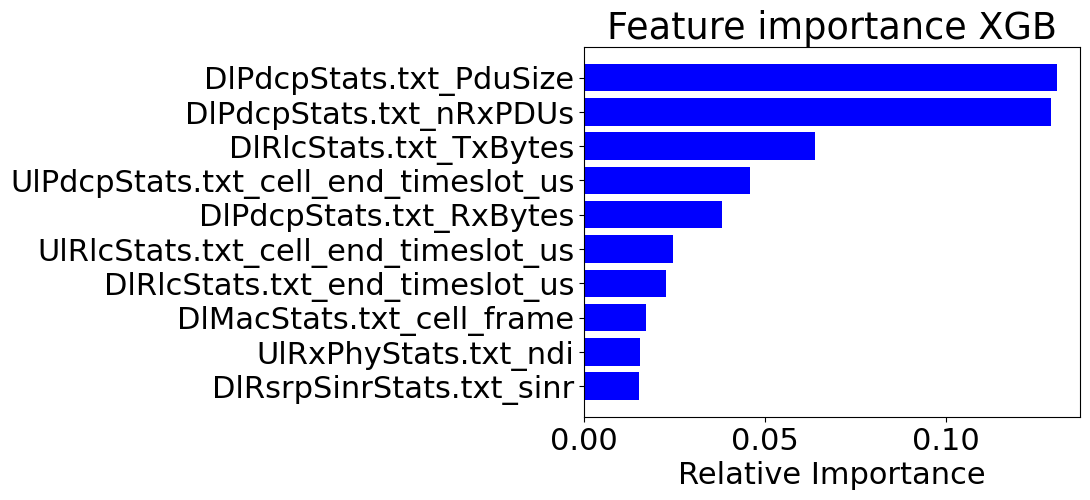

In [80]:
#=============================================== plot feature importance ==================================

if IN_PARAM['model_type'] == 'xgb':
    # The length of importances reflects the number of features used
    importances = model.feature_importances_
    # increasing order in value and hence decreasing order in importance 
    # sort the importances and then fetch the index value of those importances 
    indices = np.argsort(importances)
    #This is in ascending order of 
    bar_vals = importances[np.flip(indices)[0:feat_filter]]
    bar_names = X_feats[np.flip(indices)[0:feat_filter]]
    #print(importances[np.flip(indices)[0:feat_filter]])
    print(X_feats[np.flip(indices)[0:feat_filter]])

    top_n_features = list( set(top_n_features).union(set(bar_names)))
    print('Top n feature list: ', top_n_features)
    plt.figure()
    plt.barh(range(len(bar_vals)), np.flip(bar_vals), color='b', align='center')
    plt.yticks(range(len(bar_vals)), np.flip(bar_names))

    plt.title('Feature importance XGB')
    plt.xlabel('Relative Importance')
    #plt.savefig('plots_for_paper/feat_imp'+str(IN_PARAM['rand_seed'])+'.pdf', bbox_inches='tight')
    plt.show() 
        

In [ ]:
if classification:
    OUT_PARAM['test_prec'], OUT_PARAM['test_rec'], test_fscore, test_support = precision_recall_fscore_support(yhat_test, y_test, average='macro')
    print('ML model: Macro (acc, prec, recall) for test set: ',  OUT_PARAM['test_acc'], OUT_PARAM['test_prec'], OUT_PARAM['test_rec'])
    OUT_PARAM['test_prec'], OUT_PARAM['test_rec'], test_fscore, test_support = precision_recall_fscore_support(yhat_test, y_test, average='micro')
    print('ML model: Micro (acc, prec, recall) for test set: ',  OUT_PARAM['test_acc'], OUT_PARAM['test_prec'], OUT_PARAM['test_rec'])
    OUT_PARAM['test_prec'], OUT_PARAM['test_rec'], test_fscore, test_support = precision_recall_fscore_support(yhat_test, y_test, average='weighted')
    print('ML model: Weighted (acc, prec, recall) for test set: ',  OUT_PARAM['test_acc'], OUT_PARAM['test_prec'], OUT_PARAM['test_rec'])
    print('Average: (acc, prec, recall) for test set over runs: ', avg_acc_over_runs, avg_prec_over_runs, avg_rec_over_runs)
else:    
    print('-----------------------------------------------------------')
    print('Top n feature list size: ', len(top_n_features))
    print(top_n_features)
    print('-----------------------------------------------------------')

    print('Loss fun: ', IN_PARAM['loss'])
    print('Eval err fun: ', IN_PARAM['eval_metric'])
    # After going over all runs     
    fig, ax1 = plt.subplots(figsize=(16, 4))
    ax2 = ax1.twinx()
    ax1.plot(train_bin_uldelay_mean/train_bin_count, train_bin_err_mean/train_bin_count, 'r.-', label='XGB pred err (truth-pred)')
    #ax1.plot(train_bin_uldelay_mean/train_bin_count, train_bin_baseline_err_mean/train_bin_count, 'm.-', label='baseline pred err (truth-pred)')
    ax1.axhline(y=0, color='r', linestyle='--')
    ax1.set_ylabel('error')
    #ax1.set_ylim(-5,25)
    ax1.legend()
    plt.xlabel('uplink delay (ms)')
    plt.title('Train samples')
    plt.grid()
    ax2.set_ylabel('relative err')
    ax2.plot(train_bin_uldelay_mean/train_bin_count, train_bin_perc_err_mean/train_bin_count, 'g*-', label='XGB relative err')
    #ax2.plot(train_bin_uldelay_mean/train_bin_count, train_bin_baseline_perc_err_mean/train_bin_count, 'c*-', label='baseline relative err')
    ax2.axhline(y=0, color='g', linestyle='--')
    plt.xscale('log')
    ax1.legend(loc=6)
    ax2.legend(loc=1)
    plt.show() 

    plt.figure(figsize=(16, 2))
    plt.plot(train_bin_uldelay_mean/train_bin_count, train_bin_count, 'b*-')
    plt.xlabel('Train samples uplink delay bin (ms)')
    plt.xscale('log')
    plt.ylabel('bin count')
    plt.grid()
    plt.show()

    print('Loss fun: ', IN_PARAM['loss'])
    print('Eval err fun: ', IN_PARAM['eval_metric'])
    fig, ax1 = plt.subplots(figsize=(16, 4))
    ax2 = ax1.twinx()
    ax1.plot(test_bin_uldelay_mean/test_bin_count, test_bin_err_mean/test_bin_count, 'r.-', label='XGB pred err (truth-pred)')
    #ax1.plot(test_bin_uldelay_mean/test_bin_count, test_bin_baseline_err_mean/test_bin_count, 'm.-', label='baseline pred err (truth-pred)')
    ax1.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('uplink delay (ms)')
    ax1.set_ylabel('error')
    #ax1.set_ylim(-500,250)
    ax1.legend()
    plt.title('Test samples')
    plt.grid()
    ax2.set_ylabel('relative err')
    ax2.plot(test_bin_uldelay_mean/test_bin_count, test_bin_perc_err_mean/test_bin_count, 'g*-', label='relative err')
    #ax2.plot(test_bin_uldelay_mean/test_bin_count, test_bin_baseline_perc_err_mean/test_bin_count, 'c*-', label='baseline relative err')
    ax2.axhline(y=0, color='g', linestyle='--')
    plt.xscale('log')
    ax1.legend(loc=6)
    ax2.legend(loc=1)
    plt.show()

    plt.figure(figsize=(16, 2))
    plt.plot(test_bin_uldelay_mean/test_bin_count, test_bin_count, 'b*-')
    plt.xlabel('Test samples uplink delay bins (ms)')
    plt.ylabel('bin count')
    plt.xscale('log')
    plt.grid()
    plt.show()


In [ ]:
notebook_save_str = 'clas_using_loss_default_softprob'
os.system('cp train_and_eval_ML_models.ipynb '+'./saved_notebooks/'+notebook_save_str+'.ipynb')


In [ ]:
feat_union = ['ul_loadUe_weightBand', 'ul_loadUe_BSRestimate', 'ul_BSRestimateLcg6', 'ul_loadUe_deltaIcc', 'ul_nrOfCsiPart1Bits', 'ul_loadUe_RI', 'dl_pucchFormatType', 'ul_loadUe_BSValueLcg6', 'ul_rv', 'ul_tbSizeInBits', 'dl_loadUe_dciFormat', 'dl_loadUe_pucchResourceIndicator', 'nbm_loadUe_WBeamIndex', 'ul_loadUe_fda', 'dl_NBeamRsrpCurrent', 'dl_loadUe_transmissionAttempt', 'dl_loadUe_bbBearerRef7', 'ul_BSRestimateLcg4', 'dl_numOfPrbs', 'ul_loadUe_isTransformPrecoding', 'ul_loadUe_timingOffset', 'dl_numberOfSymbols', 'ul_BSValueLcg0', 'dl_tbSizeInBits', 'ul_loadUe_VBit', 'ul_loadUe_BSRestimateLcg2', 'ul_csiRequest', 'ul_loadUe_BSValueLcg4', 'dl_loadUe_weightBand', 'wbm_rsrp1', 'dl_loadUe_NBeamRsrpCurrent', 'ul_tpcCommand', 'ul_iccAchievable', 'ul_loadUe_preamblePwr', 'nbm_beam03', 'dl_drb5data', 'dl_pucchSfn', 'ul_loadUe_numOfLayers', 'nbm_rsrp01', 'dl_icc', 'ul_loadUe_iccAchievable', 'ul_fda', 'ul_loadUe_uciDecodedResult', 'ul_loadUe_BSValueLcg0', 'dl_dlCcIndex', 'nbm_loadUe_rsrp11', 'wbm_beam4', 'dl_loadUe_incrementalWeight', 'dl_loadUe_antennaPorts', 'ul_BSValueLcg5', 'ul_RI', 'dl_loadUe_fda', 'dl_loadUe_numBearers', 'ul_loadUe_csiRequest', 'dl_linkAdaptationUeMode', 'wbm_loadUe_cellId', 'ul_loadUe_ACK', 'dl_cellId', 'dl_bbBearerRef2', 'ul_loadUe_BSValueLcg7', 'dl_loadUe_cqi', 'dl_pdschHarqFeedbackTiming', 'dl_loadUe_pucchSfn', 'dl_loadUe_pdschHarqFeedbackTiming', 'ul_loadUe_isClpcSaturated', 'ul_loadUe_startSymbolPusch', 'dl_loadUe_dlCcIndex', 'dl_loadUe_drb7input', 'dl_bbBearerRef7', 'dl_loadUe_bbBearerRef2', 'ul_loadUe_beamIndex', 'dl_rank', 'dl_loadUe_drb4input', 'dl_numBearers', 'wbm_loadUe_beam2', 'nbm_loadUe_beam01', 'ul_loadUe_WBeamRsrpCurrent', 'ul_carrierAggregationUsed', 'nbm_loadUe_rsrp12', 'dl_drb4input', 'dl_mcsIndex', 'dl_sinr', 'dl_drb4data', 'ul_loadUe_harqProcessId', 'dl_transmissionAttempt', 'ul_loadUe_BSRestimateLcg7', 'dl_loadUe_isDrxEnabled', 'dl_drb0data', 'dl_loadUe_numOfPrbs', 'dl_loadUe_drb4data', 'ul_loadUe_numberOfSymbolsPusch', 'nbm_loadUe_ueTraceIdMsw', 'wbm_loadUe_beam3', 'dl_sectorIndex', 'dl_drb1input', 'dl_numberOfSrcBits', 'nbm_beam13', 'ul_clpcCarrierDemand', 'ul_wbUsedNbOverridden', 'ul_loadUe_puschTotalRxPsdAvg', 'dl_srOnPucch', 'dl_loadUe_sectorIndex', 'wbm_beam3', 'dl_drb0input', 'ul_BSRestimate', 'ul_BSRestimateLcg1', 'dl_loadUe_taValue', 'ul_maxRank', 'wbm_beam1', 'dl_loadUe_bbBearerRef3', 'dl_physicalCellId', 'ul_totalCellsReqScheduling', 'wbm_loadUe_beam4', 'nbm_loadUe_rsrp02', 'wbm_loadUe_WBeamIndexNewBest', 'dl_loadUe_WBeamRsrpCurrent', 'nbm_WBeamIndex', 'dl_loadUe_slot', 'dl_bbBearerRef1', 'dl_drb3data', 'nbm_loadUe_rsrp13', 'ul_macSduInBytes', 'dl_loadUe_srOnPucch', 'ul_measNumOfPrb', 'ul_transmissionAttempt', 'ul_loadUe_BSRestimateLcg3', 'dl_loadUe_deltaIcc', 'dl_dciFormat', 'ul_bbCellIndex', 'dl_loadUe_macCtrlElement', 'dl_weightBand', 'ul_loadUe_mcsIndex', 'ul_loadUe_antennaPorts', 'ul_timingOffset', 'dl_redundancyVersion', 'ul_loadUe_BSRestimateLcg1', 'ul_loadUe_wbUsedNbOverridden', 'dl_numberOfActivatedDlCells', 'dl_antennaPorts', 'dl_drb7input', 'dl_harqProcessId', 'nbm_loadUe_beam13', 'ul_loadUe_nrOfCsiPart1Bits', 'ul_dciFormat', 'dl_pucchSlotNo', 'nbm_NBeamIndexChosen', 'ul_precodingInfo', 'ul_loadUe_NBeamRsrpCurrent', 'ul_loadUe_harqFailure', 'dl_bbBearerRef4', 'dl_ndi', 'nbm_beam12', 'dl_loadUe_tda', 'nbm_loadUe_cellId', 'wbm_loadUe_WBeamIndexCurrent', 'ul_ndi', 'dl_loadUe_tbSizeInBits', 'wbm_cellId', 'dl_loadUe_icc', 'nbm_loadUe_beam02', 'dl_pucchResourceIndicator', 'ul_BSValueLcg2', 'ul_loadUe_macSduInBytes', 'ul_measNumOfLayers', 'dl_loadUe_drb1input', 'dl_WBeamRsrpCurrent', 'nbm_loadUe_noOfCriPerCsiReport', 'ul_antennaPorts', 'ul_loadUe_slot', 'wbm_beam2', 'ul_loadUe_startPrb', 'ul_slot', 'nbm_loadUe_rsrp01', 'ul_BSRestimateLcg0', 'ul_loadUe_numOfPrbs', 'ul_isDrxEnabled', 'ul_loadUe_BSRestimateLcg0', 'wbm_rsrp4', 'ul_BSValueLcg4', 'dl_loadUe_pucchSlotNo', 'ul_preamblePwr', 'wbm_loadUe_beam1', 'dl_ACK', 'ul_isPrimaryCell', 'dl_tda', 'ul_loadUe_postEqSinr0', 'dl_loadUe_sinr', 'ul_loadUe_pCmaxCIndex', 'ul_loadUe_cellId', 'dl_loadUe_physicalCellId', 'dl_loadUe_beamIndex', 'dl_loadUe_numberOfSymbols', 'dl_loadUe_drb2data', 'dl_loadUe_drb1data', 'ul_BSRestimateLcg7', 'ul_numOfLayers', 'ul_loadUe_numberOfActivatedUlCells', 'ul_loadUe_BSValueLcg1', 'nbm_beam11', 'ul_loadUe_BSValueLcg5', 'dl_loadUe_newData/reTx(1/0)', 'dl_loadUe_bbBearerRef6', 'ul_loadUe_bbCellIndex', 'nbm_loadUe_NBeamIndexChosen', 'dl_loadUe_numberOfActivatedDlCells', 'ul_isClpcSaturated', 'ul_loadUe_BSRestimateLcg5', 'ul_loadUe_tbSizeInBits', 'ul_BSValueLcg1', 'ul_loadUe_maxRank', 'dl_fda', 'ul_DTX', 'ul_loadUe_clpcCarrierDemand', 'dl_cqi', 'dl_dai', 'wbm_rsrp3', 'ul_numOfPrbs', 'dl_drb3input', 'ul_puschTotalRxPsdAvg', 'nbm_loadUe_NBeamIndexCurrent', 'nbm_cellId', 'ul_loadUe_postEqSinr1', 'dl_loadUe_drb3input', 'ul_pCmaxCIndex', 'ul_numberOfSymbolsPusch', 'dl_loadUe_mcsIndex', 'dl_newData/reTx(1/0)', 'ul_weightBand', 'nbm_rsrp02', 'ul_uciDecodedResult', 'ul_loadUe_BSValueLcg2', 'ul_powerHeadRoomIndex', 'ul_loadUe_rv', 'ul_incrementalWeight', 'dl_loadUe_drb2input', 'dl_loadUe_drb7data', 'dl_drb6input', 'wbm_rsrp2', 'dl_loadUe_bbCellIndex', 'dl_bbBearerRef3', 'dl_loadUe_feedbackIndex', 'ul_startPrb', 'ul_cellId', 'wbm_loadUe_rsrp1', 'dl_loadUe_rank', 'ul_ACK', 'ul_beamIndex', 'dl_isSrBitIncluded', 'ul_numberOfActivatedUlCells', 'dl_bbBearerRef6', 'ul_loadUe_transmissionAttempt', 'dl_loadUe_isPrimaryCell', 'wbm_loadUe_rsrp4', 'ul_BSValueLcg3', 'dl_macCtrlElement', 'dl_drb6data', 'dl_isPrimaryCell', 'ul_harqFailure', 'dl_bbCellIndex', 'ul_loadUe_totalCellsReqScheduling', 'ul_postEqSinr0', 'ul_loadUe_carrierAggregationUsed', 'dl_loadUe_bbBearerRef4', 'ul_loadUe_powerHeadRoomIndex', 'ul_BSValueLcg6', 'nbm_loadUe_beam03', 'dl_drb2data', 'nbm_rsrp13', 'dl_isDrxEnabled', 'ul_loadUe_measNumOfPrb', 'dl_feedbackIndex', 'ul_loadUe_isDrxEnabled', 'dl_loadUe_bbBearerRef1', 'ul_loadUe_ulRequestTypeBitmap', 'nbm_rsrp03', 'dl_slot', 'dl_loadUe_drb5input', 'ul_loadUe_BSRestimateLcg4', 'dl_beamIndex', 'dl_loadUe_isSrBitIncluded', 'ul_BSRestimateLcg3', 'ul_WBeamRsrpCurrent', 'dl_loadUe_DTX', 'nbm_rsrp11', 'ul_BSRestimateLcg5', 'dl_loadUe_redundancyVersion', 'ul_ulRequestTypeBitmap', 'wbm_WBeamIndexNewBest', 'ul_ulschIndicator', 'dl_drb1data', 'dl_drb2input', 'ul_loadUe_BSRestimateLcg6', 'nbm_loadUe_rsrp03', 'dl_loadUe_wbUsedNbOverridden', 'dl_loadUe_drb6input', 'nbm_loadUe_beam11', 'nbm_beam01', 'dl_loadUe_linkAdaptationUeMode', 'ul_loadUe_linkAdaptationUeMode', 'dl_loadUe_bbBearerRef0', 'dl_drb5input', 'dl_loadUe_drb6data', 'ul_loadUe_BSValueLcg3', 'dl_loadUe_drb0data', 'ul_loadUe_sinrAchievable', 'nbm_loadUe_beam12', 'ul_loadUe_incrementalWeight', 'dl_loadUe_dai', 'dl_loadUe_ueTraceIdMsw', 'ul_loadUe_ndi', 'ul_startSymbolPusch', 'dl_loadUe_cellId', 'ul_isTransformPrecoding', 'dl_loadUe_drb5data', 'dl_loadUe_drb3data', 'ul_deltaIcc', 'nbm_noOfCriPerCsiReport', 'dl_loadUe_drb0input', 'ul_mcsIndex', 'ul_chipsetType', 'dl_loadUe_numberOfSrcBits', 'nbm_beam02', 'ul_postEqSinr1', 'ul_loadUe_isPrimaryCell', 'dl_incrementalWeight', 'dl_loadUe_ACK', 'ul_BSRestimateLcg2', 'ul_NBeamRsrpCurrent', 'dl_DTX', 'dl_bbBearerRef5', 'dl_loadUe_bbBearerRef5', 'ul_harqProcessId', 'dl_loadUe_pucchFormatType', 'wbm_loadUe_rsrp2', 'dl_taValue', 'ul_loadUe_precodingInfo', 'ul_BSValueLcg7', 'wbm_loadUe_ueTraceIdMsw', 'dl_loadUe_ndi', 'dl_deltaIcc', 'dl_drb7data', 'ul_loadUe_DTX', 'ul_linkAdaptationUeMode', 'wbm_loadUe_rsrp3', 'nbm_NBeamIndexCurrent', 'dl_loadUe_harqProcessId', 'ul_loadUe_ulschIndicator', 'dl_wbUsedNbOverridden', 'ul_loadUe_measNumOfLayers', 'nbm_rsrp12', 'dl_bbBearerRef0', 'wbm_WBeamIndexCurrent', 'ul_sinrAchievable']
print(feat_union)
print(len(feat_union))

In [ ]:
# List of featurtes I think will not generalize 
filtered_cols = [i for i in feat_union if 'eamIndex' in i]
print(filtered_cols)